# ECE 763 Project 02: Vision Transformers

Objectives: 

- To get hands-on experiences on working with images (CIFAR10) and Vision Transformers and Meta-Transformers
- To get familar with PyTorch Lightning pacakge that makes the training easier

### How to submit your solutions

* Add your NCSU ID as the postfix of the notebook filename.
* Submit two versions of your notebook, one is fully executed with all outputs (`Project_02_ViT_twu19_results.ipynb`), and the other with all outputs cleared (`Project_02_ViT_twu19_empty.ipynb`). We will re-run the latter and expect the results will be exactly the same as those in the former. 

## Importing our standard set of libraries.

In [1]:

## Standard libraries
import os
import json
import math
import random
import numpy as np 
import copy
import time

from sklearn.metrics import accuracy_score

## Imports for plotting
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_theme()

## Progress bar
from tqdm.notebook import tqdm

## typing
from typing import (
    Any,
    Callable,
    Dict,
    List,
    Optional,
    Sequence,
    Set,
    Tuple,
    Type,
    Union,
)

try:
    from typing import Literal
except ImportError:
    from typing_extensions import Literal

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## PyTorch Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms


# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: 
    !pip install --quiet pytorch-lightning>=1.6
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard


## Identify the system

In [2]:
import platform
from mmengine.utils.dl_utils import collect_env
from pprint import pprint

print("=" * 40, "System Information", "=" * 40)
uname = platform.uname()
print(f"System: {uname.system}")
print(f"Node Name: {uname.node}")
print(f"Release: {uname.release}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}")
print(f"Processor: {uname.processor}")

print("=" * 40, "Environment Information", "=" * 40)
my_env = collect_env()
pprint(my_env)

======================================== System Information ========================================
System: Linux
Node Name: Chris
Release: 5.15.146.1-microsoft-standard-WSL2
Version: #1 SMP Thu Jan 11 04:09:03 UTC 2024
Machine: x86_64
Processor: x86_64
======================================== Environment Information ========================================
OrderedDict([('sys.platform', 'linux'),
             ('Python', '3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]'),
             ('CUDA available', True),
             ('MUSA available', False),
             ('numpy_random_seed', 2147483648),
             ('GPU 0', 'NVIDIA GeForce RTX 3080 Laptop GPU'),
             ('CUDA_HOME', '/usr'),
             ('NVCC', 'Cuda compilation tools, release 11.5, V11.5.119'),
             ('GCC', 'gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0'),
             ('PyTorch', '2.1.2'),
             ('PyTorch compiling details',
              'PyTorch built with:\n'
              '  - GCC 9.3\n'
         

## Set random seeds and devices

In [3]:

# Function for setting the seed
def random_seed(seed: int = 42, rank: int = 0, deterministic: bool = False) -> None:
    torch.manual_seed(seed + rank)
    np.random.seed(seed + rank)
    random.seed(seed + rank)
    # GPU operations have a separate seed we also want to set
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed + rank)
        torch.cuda.manual_seed_all(seed + rank)

        # Additionally, some operations on a GPU are implemented stochastic for efficiency
        # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
        torch.backends.cudnn.deterministic = deterministic
        torch.backends.cudnn.benchmark = True

seed = 42
random_seed(seed=seed, deterministic=True)

# Fetching the device that will be used throughout this notebook
device = (
    torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
)
print("Using device", device)

Using device cuda:0


## Prepare Datasets (CIFAR10)

In [4]:
# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../checkpoints/ece763_proj_02"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

### CIFAR10
CIFAR10 is a very popular dataset for computer vision on low-resolution images (32x32 pixels). The task is to classify images into one of 10 classes: **airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck**. 

In [5]:
# Dataset statistics for normalizing the input values to zero mean and one std
DATA_MEANS = [0.491, 0.482, 0.447]
DATA_STD = [0.247, 0.243, 0.261]

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(DATA_MEANS, DATA_STD)
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# Create data loaders for later. Adjust batch size if you have a smaller GPU
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=3)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=3)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=3)

# classes
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


When working with data, it is always recommend to look at the data before blaming your model for not performing well if the data was incorrectly processed. Hence, let's plot 1-batch images of the CIFAR10 training dataset:


In [6]:
start_time = time.time()
dataiter = iter(train_loader)
images, labels = next(dataiter)
end_time = time.time()
print(f"Time for loading a batch: {(end_time - start_time):6.5f}s")


Time for loading a batch: 0.61744s


In [7]:
INV_DATA_MEANS = torch.tensor([-m for m in DATA_MEANS]).view(-1, 1, 1)
INV_DATA_STD = torch.tensor([1.0 / s for s in DATA_STD]).view(-1, 1, 1)


def imshow(img):
    img = img.div_(INV_DATA_STD).sub_(INV_DATA_MEANS)  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()
    plt.close()


imshow(torchvision.utils.make_grid(images))
print("GroundTruth (1st row): ", " ".join(f"{classes[labels[j]]:5s}" for j in range(8)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth (1st row):  cat   frog  car   dog   frog  car   truck frog 


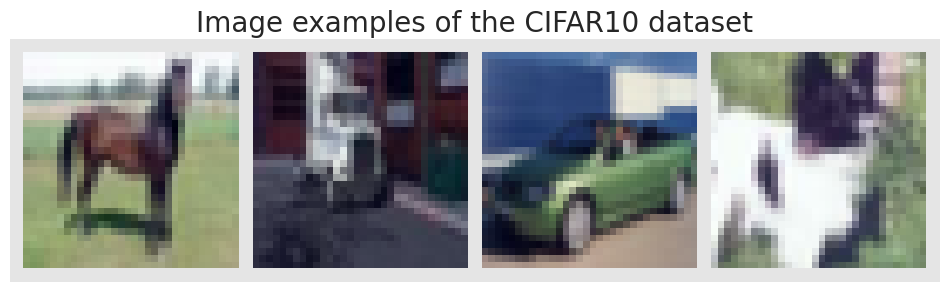

In [8]:
# For later, we keep a set of example images
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(4)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(12,8))
plt.title("Image examples of the CIFAR10 dataset", fontsize=20)
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## Part 1 [70 points]: Building a Vision Transformer for image classification

Transformers have been originally proposed to process sets since it is a permutation-equivariant architecture, i.e., producing the same output permuted if the input is permuted. To apply Transformers to sequences, one commonly adds a positional encoding to the input feature vectors, and the model learns by itself what to do with it. So, why not do the same thing on images? This is exactly what [Alexey Dosovitskiy et al.](https://openreview.net/pdf?id=YicbFdNTTy) proposed in their paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale". Specifically, the Vision Transformer is a model for image classification that views images as sequences of smaller patches. As a preprocessing step, we split an image of, for example, $48\times 48$ pixels into 9 $16\times 16$ patches. Each of those patches is considered to be a "word"/"token" and projected to a feature space. With adding positional encodings and a token for classification on top, we can apply a Transformer as usual to this sequence and start training it for our task. A nice GIF visualization of the architecture is shown below (figure credit - [Phil Wang](https://github.com/lucidrains/vit-pytorch/blob/main/images/vit.gif)):

<center width="100%"><img src="./figures/vit.gif" width="600px"></center>

We will walk step by step through the Vision Transformer, and implement all parts by ourselves. First, let's implement the image preprocessing: an image of size $N\times N$ has to be split into $(N/M)^2$ patches of size $M\times M$. These represent the input words to the Transformer. Implement this logic in the function below:

In [9]:
# 5 points
def img_to_patch(x, patch_size, flatten_channels: bool = True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, C, H, W]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    Outputs:
        torch.Tensor of shape [B, H*W/patch_size^2, C, patch_size, patch_size] if flatten_channels=False,
        and [B, H*W/patch_size^2, C*patch_size^2] otherwise.
    """
    # # TODO: Implement the splitting of images into patches
    # raise NotImplementedError
    B, C, H, W = [int(s) for s in x.size()]
    H_rem = int(H % patch_size)
    if H_rem != 0:
        # pad height dimension of x
        # (0, 0, 0, H_rem) 
        # (0, 0 - last dimension: pad left and right with nothing
        # 0, H_rem) - 2nd to last: pad left with nothing and right with remainder
        x = F.pad(x, [0, 0, 0, H_rem], "constant", 0.)
    
    W_rem = int(W % patch_size)
    if W_rem != 0:
        # pad width dimension of x
        # (0, W_rem) - pad last dimension with nothing on left & remainder on right
        x = F.pad(x, [0, W_rem], "constant", 0.)

    B, C, H, W = [int(s) for s in x.size()]
    patches = torch.zeros(B, int(H*W/(patch_size ** 2)), C, patch_size, patch_size).to(x.device)
    cnt = 0
    for i in range(int(H / patch_size)):
        for j in range(int(W / patch_size)):
            patches[:, cnt, :, :, :] = x[:, :, i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
            cnt += 1

    if flatten_channels:
        return torch.flatten(patches, start_dim=-3)

    return patches

In [10]:
imgs = torch.randn(4, 3, 48, 48)
patch_size = 16
out = img_to_patch(imgs, patch_size, flatten_channels=False)
assert len(out.shape) == 5
assert out.shape[0] == imgs.shape[0]
assert out.shape[1] == imgs.shape[2]*imgs.shape[3]/patch_size**2
assert out.shape[2] == imgs.shape[1]
assert out.shape[3] == patch_size
assert out.shape[4] == patch_size

out = img_to_patch(imgs, patch_size, flatten_channels=True)
assert len(out.shape) == 3
assert out.shape[0] == imgs.shape[0]
assert out.shape[1] == imgs.shape[2]*imgs.shape[3]/patch_size**2
assert out.shape[2] == imgs.shape[1]*patch_size**2

Let's take a look at how that works for our CIFAR examples above. For our images of size $32\times 32$, we choose a patch size of 4. Hence, we obtain sequences of 64 patches of size $4\times 4$. We visualize them below:

In [11]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()

Compared to the original images, it is much harder to recognize the objects from those patch lists now. Still, this is the input we provide to the Transformer for classifying the images. The model has to learn itself how it has to combine the patches to recognize the objects. The inductive bias in CNNs that an image is a grid of pixels, is lost in this input format.

After we have looked at the preprocessing, we can now start building the Transformer model. You can make use of the PyTorch module `nn.MultiheadAttention` ([docs](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html?highlight=multihead#torch.nn.MultiheadAttention)) here. Further, we use the Pre-Layer Normalization version of the Transformer blocks proposed by [Ruibin Xiong et al.](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf) in 2020. The idea is to apply Layer Normalization not in between residual blocks, but instead as a first layer in the residual blocks. This reorganization of the layers supports better gradient flow and removes the necessity of a warm-up stage. A visualization of the difference between the standard Post-LN and the Pre-LN version is shown below.

<center width="100%"><img src="figures/pre_layer_norm.svg" width="400px"></center>

First, implement a Pre-LN attention block below:

In [12]:
# 20 points
class AttentionBlock(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim, num_heads, dropout=0.0):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            hidden_dim - Dimensionality of hidden layer in feed-forward network 
                         (usually 2-4x larger than embed_dim)
            num_heads - Number of heads to use in the Multi-Head Attention block
            dropout - Amount of dropout to apply in the feed-forward network
        """
        super().__init__()
        # # TODO: Implement an pre-LN attention block
        # raise NotImplementedError
        self.embed_dim = embed_dim
        self.num_heads = num_heads        
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        
        self.layer_norm0 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=False)

        # as defined in the paper:
        # "This [FFN] sub-layer is a two-layer feed-forward network with a ReLU activation
        # function. Given a sequence of vectors h_1, ..., h_n, the computation of a 
        # position-wise FFN sub-layer on any h_i is defined as:
        #
        #     FFN(h_i) = ReLU((h_i)W^1 + b^1)W^2 + b^2
        #
        # where W^1, W^2, b^1 & b^2 are parameters."
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
        )
        
    def forward(self, x):
        """
        Inputs:
            x - Input tensor of shape [Num Patches, Batch size, embed_dim]
        """
        # # TODO: Implement the forward pass
        # raise NotImplementedError
        x_ln0 = self.layer_norm0(x)
        x_mha, mha_weights = self.mha(x_ln0, x_ln0, x_ln0)
        x_0 = torch.add(x, x_mha)

        x_ln1 = self.layer_norm1(x_0)
        x_ffn = self.ffn(x_ln1)
        x_1 = torch.add(x_0, x_ffn)
        return x_1

In [13]:
# Testing the attention block
num_heads = np.random.randint(low=4, high=16)
embed_dim = num_heads * np.random.randint(low=16, high=32)
hidden_dim = np.random.randint(low=128, high=512)
block = AttentionBlock(embed_dim, hidden_dim, num_heads)
block.to(device)
inp = torch.randn(10, 32, embed_dim, device=device)
out = block(inp)
for i in range(len(inp.shape)):
    assert out.shape[i] == inp.shape[i]

# Checking whether batch and patch dimension are correct
inp2 = inp.clone()
inp2[:,0] = 0.0
out2 = block(inp2)
diff = (out - out2).abs()
assert (diff[:,0] > 1e-4).any(), 'Output tensor shows no difference although input has changed'
assert (diff[:,1:] < 1e-4).all(), 'Other tensors besides the changed batch element have altered outputs. Check the dimensions'

Now we have all modules ready to build our own Vision Transformer. Besides the Transformer encoder, we need the following modules:

* A **linear projection** layer that maps the input patches to a feature vector of larger size. It is implemented by a simple linear layer that takes each $M\times M$ patch independently as input.
* A **classification token** that is added to the input sequence. We will use the output feature vector of the classification token (CLS token in short) for determining the classification prediction.
* Learnable **positional encodings** that are added to the tokens before being processed by the Transformer. Those are needed to learn position-dependent information, and convert the set to a sequence. Since we usually work with a fixed resolution, we can learn the positional encodings instead of having the pattern of sine and cosine functions.
* An **MLP head** that takes the output feature vector of the CLS token, and maps it to a classification prediction. This is usually implemented by a small feed-forward network or even a single linear layer.

With those components in mind, let's implement the full Vision Transformer below:

In [14]:
# 20 points
class VisionTransformer(nn.Module):
    
    def __init__(
        self,
        embed_dim: int,
        hidden_dim: int,
        num_channels: int,
        num_heads: int,
        num_layers: int,
        num_classes: int,
        patch_size: int,
        num_patches: int,
        dropout: float = 0.0,
        use_pos_enc: bool = True,
    ):
        """
        Inputs:
            embed_dim - Dimensionality of the input feature vectors to the Transformer
            hidden_dim - Dimensionality of the hidden layer in the feed-forward networks
                         within the Transformer
            num_channels - Number of channels of the input (3 for RGB)
            num_heads - Number of heads to use in the Multi-Head Attention block
            num_layers - Number of layers to use in the Transformer
            num_classes - Number of classes to predict
            patch_size - Number of pixels that the patches have per dimension
            num_patches - Maximum number of patches an image can have
            dropout - Amount of dropout to apply in the feed-forward network and 
                      on the input encoding
            use_pos_enc - boolean to use positional encoding or not
        """
        super().__init__()
        # # TODO: Implement all elements of the full Vision Transform
        # raise NotImplementedError
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.num_channels = num_channels
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.dropout = dropout
        self.use_pos_enc = use_pos_enc

        self.patch_linear_projection = nn.Linear(num_channels * (patch_size ** 2), embed_dim)
        # classification token to be learned
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # TODO: make multiplication a random number (provide rng)
        # positional encoding to be learned. num_patches + 1 as we will also be encoding the cls_token
        # that is concatenated with the input
        self.pos_enc = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim) * 0.03)

        # Transformer encoding blocks
        self.attention = nn.Sequential(*[
            AttentionBlock(
                embed_dim=embed_dim,
                hidden_dim=hidden_dim,
                num_heads=num_heads,
                dropout=dropout,
            )
        for _ in range(num_layers)])
        
        # project class token to predict classes
        self.ln_proj_cls = nn.LayerNorm(embed_dim)
        self.proj_cls_to_class_pred = nn.Linear(embed_dim, num_classes)

        self.init_weights()
    
    def init_weights(self):
        # from timm
        nn.init.normal_(self.cls_token, std=1e-6)

    def forward(self, x):
        # # TODO: Implement the forward pass
        # raise NotImplementedError
        """
        Inputs:
            x - Input tensor of shape [Batch size, Channels, Height, Width]
        """
        # 1st - need to transform input images into a sequence of flattened patches
        # From 'An Image Is Worth 16x16 Words: Transformers For Image Recognition At Scale
        #
        # x in R^{H x W x C}
        # 
        # into a sequence of flattened 2D patches
        #
        # x_p in R^{N x (P^2 * C)}
        #
        # where (H, W) is the resolution of the original image, C is the number of channels,
        # (P, P) is the resolution of each image patch (i.e. patch_size), and N = HW/P^2
        # is the resulting number of patches, which also serves as the effective input sequence
        # length for the Transformer.

        # results in [Batch size, N, C * P^2] shape tensor
        x_patches = img_to_patch(x, self.patch_size, flatten_channels=True)

        #
        # 2nd - The Transformer uses constant latent vector size D (embed_size) through all
        # of its layers, so we flatten the patches and map to D dimensions with a
        # trainable linear projection. The output of this projection is the patch embeddings.

        # results in [Batch size, N, embed_dim] shape tensor
        x_proj = self.patch_linear_projection(x_patches)

        #
        # 3rd - concatenate classification token to input sequence

        # results in [Batch size, N + 1, embed_dim] shape tensor
        # expand cls_token to match batch size of x
        shape_ = int(x_proj.size()[0])
        cat_cls = [self.cls_token.expand(shape_, -1, -1)]
        x_cls_token = torch.cat(cat_cls + [x_proj], dim=1)

        x_pos_enc = x_cls_token
        if self.use_pos_enc:
            #
            # 4th - implement positional encoding, note that we are also encoding position
            # into the cls_token
            x_pos_enc = x_cls_token + self.pos_enc

        #
        # 5th - go through the Transformer encoding blocks

        # need to permute our tensor to be of shape [N + 1, Batch size, embed_dim] as that is what our attention block is expecting
        # alternatively, we could create an argument for self.attention() 'batch_first' and set it to True, but we will not.
        x_mha = self.attention(x_pos_enc.permute(1, 0, 2)).permute(1, 0, 2)

        #
        # 6th - project class tokens to logits for classification
        x_logits = self.proj_cls_to_class_pred(self.ln_proj_cls(x_mha[:, 0]))

        return x_logits

In [15]:
# Testing the Vision Transformer module
num_heads = np.random.randint(low=4, high=16)
embed_dim = num_heads * np.random.randint(low=16, high=32)
hidden_dim = np.random.randint(low=128, high=512)
num_channels = 3
num_layers = np.random.randint(low=2, high=4)
num_classes = np.random.randint(low=5, high=20)
patch_size = [2,4,8][np.random.randint(low=0, high=3)]
num_patches = int((32/patch_size)**2)

print(f"num_heads: {num_heads}\n"
        f"embed_dim: {embed_dim}\n"
        f"hidden_dim: {hidden_dim}\n"
        f"num_channels: {num_channels}\n"
        f"num_layers: {num_layers}\n"
        f"num_classes: {num_classes}\n"
        f"patch_size: {patch_size}\n"
        f"num_patches: {num_patches}"
     )

vit_module = VisionTransformer(embed_dim, hidden_dim, num_channels, num_heads, num_layers, num_classes, patch_size, num_patches)
vit_module.to(device)
imgs = torch.randn(4, 3, 32, 32, device=device)
out = vit_module(imgs)
assert out.shape[0] == imgs.shape[0]
assert out.shape[1] == num_classes

# Checking whether batch and patch dimension are correct
imgs2 = imgs.clone()
imgs2[0] = 0.0
out2 = vit_module(imgs2)
diff = (out2 - out).abs()
assert (diff[0] > 1e-4).any(), 'Output tensor shows no difference although input has changed'
assert (diff[1:] < 1e-4).all(), 'Other tensors besides the changed batch element have altered outputs. Check the dimensions'

num_heads: 14
embed_dim: 322
hidden_dim: 316
num_channels: 3
num_layers: 2
num_classes: 11
patch_size: 4
num_patches: 64


Finally, we can put everything into a PyTorch Lightning Module as usual. We use `torch.optim.AdamW` as the optimizer, which is Adam with a corrected weight decay implementation. Since we use the Pre-LN Transformer version, we do not need to use a learning rate warmup stage anymore.

In [16]:
# 15 points
class BasePyLightningClassification(pl.LightningModule):
    
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        # self.model = VisionTransformer(**model_kwargs)
        self.example_input_array = next(iter(train_loader))[0]
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-3)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 90], gamma=0.1)
        return [optimizer], [lr_scheduler]   

    def _calculate_accuracy(self, batch, mode="train"):
        logits, target = batch
        self.log(f"{mode}_acc", accuracy_score(target.detach().cpu(), torch.argmax(logits, dim=1).detach().cpu()))
    
    def _calculate_loss(self, batch, mode="train"):
        # # TODO: Implement step to calculate the loss and accuracy for a batch
        # raise NotImplementedError
        logits, target = batch
        loss = self.criterion(logits, target)
        self.log(f"{mode}_loss", loss)
        return loss
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        self._calculate_accuracy([logits, y], mode="train")
        loss = self._calculate_loss([logits, y], mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        self._calculate_accuracy([logits, y], mode="val")
        loss = self._calculate_loss([logits, y], mode="val")
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        self._calculate_accuracy([logits, y], mode="test")
        loss = self._calculate_loss([logits, y], mode="test")
        return loss


class ViT(BasePyLightningClassification):
    def __init__(self, model_kwargs, lr):
        super().__init__(lr)
        self.model = VisionTransformer(**model_kwargs)

### Experiments

Commonly, Vision Transformers are applied to large-scale image classification benchmarks such as ImageNet to leverage their full potential. However, here we take a step back and ask: can Vision Transformer also succeed on classical, small benchmarks such as CIFAR10? To find this out, we train a Vision Transformer from scratch on the CIFAR10 dataset. Let's first create a training function for our PyTorch Lightning module which also loads the pre-trained model if you have downloaded it above.

In [17]:
def train_model(model_name: str, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_name), 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=10)
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = ViT.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = ViT(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = ViT.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

Now, we can already start training our model. As seen in our implementation, we have a couple of hyperparameters that we have to set. When creating this notebook, we have performed a small grid search over hyperparameters and listed the best hyperparameters in the cell below. Nevertheless, it is worth discussing the influence that each hyperparameter has, and what intuition we have for choosing its value.

First, let's consider the patch size. The smaller we make the patches, the longer the input sequences to the Transformer become. While in general, this allows the Transformer to model more complex functions, it requires a longer computation time due to its quadratic memory usage in the attention layer. Furthermore, small patches can make the task more difficult since the Transformer has to learn which patches are close-by, and which are far away. We experimented with patch sizes of 2, 4, and 8 which gives us the input sequence lengths of 256, 64, and 16 respectively. We found 4 to result in the best performance and hence pick it below. 

Next, the embedding and hidden dimensionality have a similar impact on a Transformer as to an MLP. The larger the sizes, the more complex the model becomes, and the longer it takes to train. In Transformers, however, we have one more aspect to consider: the query-key sizes in the Multi-Head Attention layers. Each key has the feature dimensionality of `embed_dim/num_heads`. Considering that we have an input sequence length of 64, a minimum reasonable size for the key vectors is 16 or 32. Lower dimensionalities can restrain the possible attention maps too much. To reduce the computational complexity, we recommend using 4 heads, 128 embedding dimensionality and 256 hidden dimensionality for a start.

Finally, the learning rate for Transformers is usually relatively small, and in papers, a common value to use is 3e-5. However, since we work with a smaller dataset and have a potentially easier task, we found that we are able to increase the learning rate to 3e-4 without any problems.

Feel free to explore the hyperparameters yourself by changing the values below. **For a final run for the report, we recommend to increase the epochs to 100**.

In [18]:
n_patches_from_patch_size: dict[int, int] = {
    2: 256,
    4: 64,
    8: 16,
}

skip: bool = True

if not skip:
    patch_sizes: list[int] = [2, 4, 8] * 2
    dropouts: list[float] = [*[0.] * 3, *[0.2] * 3]
    results_iter: dict[str, Any] = {}
    model_names_ViT_w_pos_enc: list[str] = []
    for patch_size, dropout in zip(patch_sizes, dropouts):
        dropout_str = f"{dropout}".replace(".", "pt")
        patch_size_and_dropout_info = f"patch_size-{patch_size}--dropout-{dropout_str}"
        model_name = f"ViT--{patch_size_and_dropout_info}"
        model_names_ViT_w_pos_enc.append(model_name)
        model, results = train_model(model_kwargs={
                                        'embed_dim': 128,
                                        'hidden_dim': 256,
                                        'num_heads': 8,
                                        'num_layers': 6,
                                        'patch_size': patch_size,
                                        'num_channels': 3,
                                        'num_patches': n_patches_from_patch_size[patch_size],
                                        'num_classes': 10,
                                        'dropout': dropout
                                      },
                                      lr=3e-4,
                                      max_epochs=10,
                                      model_name=model_name)
        print(f"ViT results: patch_size, dropout = ({patch_size}, {dropout})\n\t{results}")
        results_iter[patch_size_and_dropout_info] = results.copy()
    
    for key, val in results_iter.items():
      print(f"{key}:\n\t{val}\n")

In [19]:
if not skip:
    # Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
    %tensorboard --logdir f'../checkpoints/ece763_proj_02/{model_names_ViT_w_pos_enc[0]}' --port 6006
    %tensorboard --logdir f'../checkpoints/ece763_proj_02/{model_names_ViT_w_pos_enc[1]}' --port 6007
    %tensorboard --logdir f'../checkpoints/ece763_proj_02/{model_names_ViT_w_pos_enc[2]}' --port 6008
    %tensorboard --logdir f'../checkpoints/ece763_proj_02/{model_names_ViT_w_pos_enc[3]}' --port 6009
    %tensorboard --logdir f'../checkpoints/ece763_proj_02/{model_names_ViT_w_pos_enc[4]}' --port 6010
    %tensorboard --logdir f'../checkpoints/ece763_proj_02/{model_names_ViT_w_pos_enc[5]}' --port 6011

In [20]:
patch_size = 2
dropout = 0.2
model_name = "ViT--epochs-100"
model, results = train_model(model_kwargs={
                                'embed_dim': 128,
                                'hidden_dim': 256,
                                'num_heads': 8,
                                'num_layers': 6,
                                'patch_size': patch_size,
                                'num_channels': 3,
                                'num_patches': n_patches_from_patch_size[patch_size],
                                'num_classes': 10,
                                'dropout': dropout
                              },
                              lr=3e-4,
                              max_epochs=100,
                              model_name=model_name)
print(f"ViT results: patch_size, dropout = ({patch_size}, {dropout})\n\t{results}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 42
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: ../checkpoints/ece763_proj_02/ViT--epochs-100/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | In sizes         | Out sizes
-------------------------------------------------------------------------------
0 | criterion | CrossEntropyLoss  | 0      | ?                | ?        
1 | model     | VisionTransformer | 831 K  | [128, 3, 32, 32] | [128, 10]
-----------------------------

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=100` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/tmp/ipykernel_315399/166467554.py:15: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  B, C, H, W = [int(s) for s in x.size()]
/tmp/ipykernel_315399/166467554.py:30: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  B, C, H, W = [int(s) for s in x.size()]
/tmp/ipykernel_315399/4121132355.py:111: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a

Testing: |                                                                                                    …

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/tmp/ipykernel_315399/166467554.py:15: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  B, C, H, W = [int(s) for s in x.size()]
/tmp/ipykernel_315399/166467554.py:30: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  B, C, H, W = [int(s) for s in x.size()]
/tmp/ipykernel_315399/4121132355.py:111: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trac

Testing: |                                                                                                    …

ViT results: patch_size, dropout = (2, 0.2)
	{'test': 0.7585999965667725, 'val': 0.7612000107765198}


In [21]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir f"../checkpoints/ece763_proj_02/{model_name}" --port 6012

What accuracy does the ViT achieve? How does this compare to the CNN you have implemented in Project 01? 


### Discussions [10 points]: Add the plots of the validation accuracy and a discussion of the previous questions here

The ViT trained using a patch size of 2, dropout of 0.2 and 100 epochs is able to achieve a resulting testing & validation accuracy metric of 75.86% & 76.12%, respectively. This is better accuracy than what we were able to achieve using the CNN in Project 01, as the validation accuracy was 72.16% and the test accuracy was 72.08%. However, the ViT we trained here was trained over 100 epochs with a constant learning rate of 3e-4, while the CNN in Project 01 was only trained over 30 epochs with a much higher initial learning rate of 0.1 that was switched to 1e-3 after 17 epochs. So we could argue that training the CNN longer may have reduced the gap between the accuracy scores between the ViT and CNN, but when we trained our CNN we noticed there was not any significant change in the validation and testing accuracies of the CNN over its last 10 epochs. Perhaps the CNN we trained initially was at its global minimum for minimizing the loss, or it was stuck in a local minimum. Another difference between the two models is that we used our own implementation of Stochastic Gradient Descent (SGD) with momentum for training the CNN as opposed to using the Adam Optimizer when training our ViT. The Adam Optimizer is the current state of the art (SOTA) optimizer, as it implements adaptive learning rates for each parameter, which could be providing a boost to the ViT in training. So we can argue that our ViT was trained using a better optimizer, thus, has a better chance to find the global minimum in less epochs than the CNN, so there is a possibility that the CNN's testing and validation accuracies could be increased if we were to retrain it with the more efficient optimizer, Adam.

Taking a look at the plots of the training of our ViT below, we can see that the training accuracy is nearing around 100% while the validation and testing accuracy lags behind by ~25%. We also notice that our validation loss begins increasing rapidly at an inflection point during training. Both of these facts imply that our model is overfit to our data and would not generalize very well. The previously identified inflection point, which would correspond to ~72.2% validation accuracy and ~85% training accuracy, would be a more viable, generalizable model than the resulting model after 100 epochs. So, if we don't modify our existing architecture and/or training scheme for our ViT model, then we would ideally want to take this model, at the inflection point, over the model after 100 epochs. Therefore, if we were to compare this "ideal" model at the inflection point with our previous CNN model, then we would see the ViT performs very similarly to the CNN with regard to the validation accuracy and slightly better than the CNN with regard to training accuracy, perhaps still implying our model may be slightly overfit.

Furthermore, the training data we used to train our CNN in the previous project was augmented with some transformations, which may have helped avoid overfitting in the CNN model training. Therefore, a next step we might make would be to halve the number of epochs we train our ViT with and augment our training data similarly to in Project 01 to identify if this helps our ViT model avoid overfitting to the training data. We could also begin to explore different activation functions, learning rates and learning rate schemes, number of heads, embedded dimensions size, and the hidden dimensions size. We may also be inclined to use the sinusoidal positional encoding method described in many other papers talking about Transformers.

Additionally, the ViT we trained has 831K trainable parameters, while the CNN in Project 01 had 338K trainable parameters. Therefore, our ViT model is bulkier than the CNN we initially trained, which could be a trade-off depending on the application of the model, e.g., if the model needed to run in bare metal, the ViT may be less suitable than the CNN.

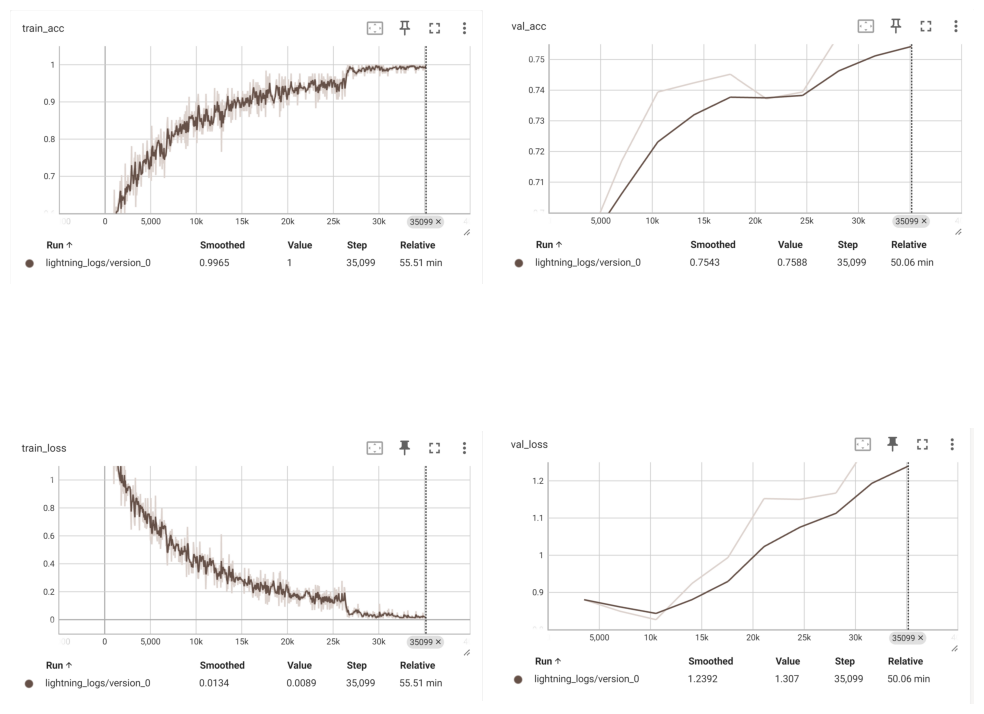

In [22]:
plots_path = "../plots-ViT--epochs-100"
train_acc_path = f"{plots_path}/train_acc.PNG"
train_loss_path = f"{plots_path}/train_loss.PNG"
val_acc_path = f"{plots_path}/val_acc.PNG"
val_loss_path = f"{plots_path}/val_loss.PNG"

import cv2
train_acc = cv2.imread(train_acc_path)
train_loss = cv2.imread(train_loss_path)
val_acc = cv2.imread(val_acc_path)
val_loss = cv2.imread(val_loss_path)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].set_axis_off()
ax[0][0].imshow(train_acc)

ax[0][1].set_axis_off()
ax[0][1].imshow(val_acc)

ax[1][0].set_axis_off()
ax[1][0].imshow(train_loss)

ax[1][1].set_axis_off()
ax[1][1].imshow(val_loss)

fig.tight_layout()
plt.show()

## Part 2 [10 points]: Importance of Positional Embeddings

From Homework 3, we have some theoretical understanding of the importance of position embeddings. However, how important are those to the Transformer actually in practice? Do we see a noticable accuracy drop if we don't use the position embeddings? Or is it looking at the images as a big bag of words anyways? Finally, how does this relation change when using different patch sizes? These questions you should try to find an answer in this ablation study. 

Specifically, train a Transformer without positional embeddings, and compare it to your original Transformer. Repeat the experiment for a smaller patch size (4 or even 2) and compare how the accuracies have changed.

In [23]:
# TODO: your experiments here
skip: bool = True

if not skip:
    patch_sizes: list[int] = [2, 4, 8]
    dropouts: list[float] = [0.] * 3
    results_iter_no_pos_enc: dict[str, Any] = {}
    model_names_ViT_wo_pos_enc: list[str] = []
    for patch_size, dropout in zip(patch_sizes, dropouts):
        dropout_str = f"{dropout}".replace(".", "pt")
        patch_size_and_dropout_info = f"patch_size-{patch_size}--dropout-{dropout_str}"
        model_name = f"ViT--{patch_size_and_dropout_info}--no-pos-enc"
        model_names_ViT_wo_pos_enc.append(model_name)
        model, results = train_model(model_kwargs={
                                        'embed_dim': 128,
                                        'hidden_dim': 256,
                                        'num_heads': 8,
                                        'num_layers': 6,
                                        'patch_size': patch_size,
                                        'num_channels': 3,
                                        'num_patches': n_patches_from_patch_size[patch_size],
                                        'num_classes': 10,
                                        'dropout': dropout,
                                        'use_pos_enc': False
                                    },
                                    lr=3e-4,
                                    max_epochs=10,
                                    model_name=model_name)
        print(f"ViT results: patch_size, dropout = ({patch_size}, {dropout})\n\t{results}")
        results_iter_no_pos_enc[patch_size_and_dropout_info] = results.copy()
    
    for key, val in results_iter_no_pos_enc.items():
      print(f"{key}:\n\t{val}\n")

In [24]:
if not skip:
    # Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
    %tensorboard --logdir f'../checkpoints/ece763_proj_02/{model_names_ViT_wo_pos_enc[0]}' --port 6013
    %tensorboard --logdir f'../checkpoints/ece763_proj_02/{model_names_ViT_wo_pos_enc[1]}' --port 6014
    %tensorboard --logdir f'../checkpoints/ece763_proj_02/{model_names_ViT_wo_pos_enc[2]}' --port 6015

### Bonous [5 points]: How to use a depthwise convolution to faciliate the positional encoding based on the reference paper in Problem 1 of HW03


In [25]:
# TODO: your codes here

## Part 3 [20 points]: Meta-Transformer

Play with two out of the four options proposed in [MetaFormer](https://arxiv.org/pdf/2210.13452.pdf), see Fig.2. 

Re-implementation your `AttentionBlock` based on the two options you choose and then test them and compare the performance. 

In [26]:
# TODO: your codes here
class StarReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.s = nn.Parameter(torch.tensor([0.8994]))
        self.b = nn.Parameter(torch.tensor([-0.4472]))
        self.relu = nn.ReLU()

    def forward(self, x):
        return (self.s * torch.square(self.relu(x))) + self.b


def solve_for_padding_w_const_kernel_size(input: int, kernel_size: int, stride: int = 1, dilation: int = 1) -> int:
    output = input
    padding = (((output - 1) * stride) - input + kernel_size) / 2
    return padding


class ConvFormerBlock(nn.Module):
    def __init__(self, embed_dim: int, num_patches: int, expansion_factor: int = 2):
        """
        Inputs:
            embed_dim - Dimensionality of input and attention feature vectors
            expansion_factor - 
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.expansion_factor = expansion_factor

        # from "MetaFormer Baselines for Vision" the Separable Convolutions block
        # is followed from the inverted separable convolution module in MobileNetV2 as:
        #
        #     Convolutions(X) = Conv_pw2(Conv_dw(sigma(Conv_pw1(X))))
        #
        # where Conv_pw1(.) & Conv_pw2(.) are pointwise convolutions, Conv_dw(.) is the
        # depthwise convolution, and sigma(.) means the non-linear activation function.
        # In practice, we set the kernel size as 7 following [3] and the expansion ratio
        # as 2.
        expanded_embed_dim = embed_dim * expansion_factor
        self.Conv_pw1 = nn.Conv1d(embed_dim, expanded_embed_dim, kernel_size=1)
        self.star_ReLU = StarReLU()
        padding = solve_for_padding_w_const_kernel_size(
            input=num_patches,
            kernel_size=7,
        )
        self.Conv_dw = nn.Conv2d(expanded_embed_dim, expanded_embed_dim, kernel_size=7, padding=int(padding), groups=expanded_embed_dim)
        self.Conv_pw2 = nn.Conv1d(expanded_embed_dim, embed_dim, kernel_size=1)

        self.block = nn.Sequential(
            self.Conv_pw1,
            self.star_ReLU,
            self.Conv_dw,
            self.Conv_pw2,
        )
        
    def forward(self, x):
        """
            x - tensor of shape [Batch size, patches, C * P^2]
        """
        # rearrange channels of x to get [Batch size, C * P^2, patches] in order to properly
        # mix the tokens or patches
        x = x.permute(0, 2, 1)
        x_conv_pw1 = self.star_ReLU(self.Conv_pw1(x))
        x_conv_pw1_expanded = x_conv_pw1.unsqueeze(-1).expand(-1, -1, -1, int(x_conv_pw1.size()[-1]))
        x_conv_dw = self.star_ReLU(self.Conv_dw(x_conv_pw1_expanded))
        x_conv_dw_reduced = F.max_pool2d(x_conv_dw, kernel_size=(1, int(x_conv_dw.size()[-1]))).squeeze()
        x_conv_pw2 = self.Conv_pw2(x_conv_dw_reduced)
        # x = self.block(x)
        # rearrange channels of x back to [Batch size, patches, C * P^2]
        x = x_conv_pw2.permute(0, 2, 1)
        return x


class ConvTransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, n_patches: int, hidden_dim: int, expansion_factor: int = 2, dropout: float = 0.0):
        super().__init__()

        self.layer_norm0 = nn.LayerNorm(embed_dim)
        self.convformer_block = ConvFormerBlock(embed_dim, n_patches, expansion_factor)

        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            StarReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
        )

    def forward(self, x):
        x_ln0 = self.layer_norm0(x)
        x_convformer = self.convformer_block(x_ln0)
        x_0 = torch.add(x, x_convformer)

        x_ln1 = self.layer_norm1(x_0)
        x_ffn = self.ffn(x_ln1)
        x_1 = torch.add(x_0, x_ffn)
        return x_1


class RandomMixingBlock(nn.Module):
    def __init__(self, num_patches: int):
        super().__init__()
        # from "MetaFormer Baselines for Vision"
        self.rand_mix = nn.Linear(num_patches, num_patches, bias=False)
        self.rand_mix.requires_grad = False

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.rand_mix(x)
        x = x.permute(0, 2, 1)
        return x


class RandomMixingTransformerBlock(nn.Module):
    def __init__(self, embed_dim: int, n_patches: int, hidden_dim: int):
        super().__init__()

        self.layer_norm0 = nn.LayerNorm(embed_dim)
        self.random_mixing_block = RandomMixingBlock(n_patches)

        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            StarReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
        )

    def forward(self, x):
        x_ln0 = self.layer_norm0(x)
        x_rand_mix = self.random_mixing_block(x_ln0)
        x_0 = torch.add(x, x_rand_mix)

        x_ln1 = self.layer_norm1(x_0)
        x_ffn = self.ffn(x_ln1)
        x_1 = torch.add(x_0, x_ffn)
        return x_1


class MetaTransformer(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        hidden_dim: int,
        num_layers: int,
        num_channels: int,
        num_patches: int,
        patch_size: int,
        num_classes: int,
        transformer_block: Callable,
        dropout: float = 0.,
        use_pos_enc: bool = True,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_channels = num_channels
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.num_classes = num_classes
        self.dropout = dropout
        self.use_pos_enc = use_pos_enc
        
        self.patch_linear_projection = nn.Linear(num_channels * (patch_size ** 2), embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_enc = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim) * 0.03)

        self.transformer_blocks = nn.Sequential(*[transformer_block for _ in range(num_layers)])

        self.ln_proj_cls = nn.LayerNorm(embed_dim)
        self.proj_cls_to_class_pred = nn.Linear(embed_dim, num_classes)

        self.init_weights()

    def init_weights(self):
        nn.init.normal_(self.cls_token, std=1e-6)

    def forward(self, x):
        x_patches = img_to_patch(x, self.patch_size, flatten_channels=True)
        x_proj = self.patch_linear_projection(x_patches)
        shape_ = int(x_proj.size()[0])
        cat_cls = [self.cls_token.expand(shape_, -1, -1)]
        x_cls_token = torch.cat(cat_cls + [x_proj], dim=1)

        x_pos_enc = x_cls_token
        if self.use_pos_enc:
            x_pos_enc += self.pos_enc

        x_transblocks = self.transformer_blocks(x_pos_enc)
        x_logits = self.proj_cls_to_class_pred(self.ln_proj_cls(x_transblocks[:, 0]))

        return x_logits

In [27]:
# test ConvFormer MetaTransformer
embed_dim = 128
hidden_dim = 256
num_layers = 6
num_channels = 3
num_patches = 64
patch_size = 4
num_classes = 10
transformer_block = ConvTransformerBlock(embed_dim, num_patches + 1, hidden_dim)

meta_conv_transformer_model = MetaTransformer(
    embed_dim,
    hidden_dim,
    num_layers,
    num_channels,
    num_patches,
    patch_size,
    num_classes,
    transformer_block,
)
meta_conv_transformer_model.to(device)
imgs = torch.randn(4, 3, 32, 32, device=device)
out = meta_conv_transformer_model(imgs)

assert out.shape[0] == imgs.shape[0]
assert out.shape[1] == num_classes

In [28]:
embed_dim = 128
hidden_dim = 256
num_layers = 6
num_channels = 3
num_patches = 64
patch_size = 4
num_classes = 10
transformer_block = RandomMixingTransformerBlock(embed_dim, num_patches + 1, hidden_dim)

meta_random_mixing_transformer_model = MetaTransformer(
    embed_dim,
    hidden_dim,
    num_layers,
    num_channels,
    num_patches,
    patch_size,
    num_classes,
    transformer_block,
)
meta_random_mixing_transformer_model.to(device)
imgs = torch.randn(4, 3, 32, 32, device=device)
out = meta_random_mixing_transformer_model(imgs)

assert out.shape[0] == imgs.shape[0]
assert out.shape[1] == num_classes

In [29]:
class MetaTransformerLightning(BasePyLightningClassification):

    def __init__(self, model_kwargs, lr):
        super().__init__(lr)
        self.model = MetaTransformer(**model_kwargs)

In [30]:
def train_meta_model(model_name: str, max_epochs=100, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_name), 
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=10)
    trainer.logger._log_graph = True         # If True, we plot the computation graph in tensorboard
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"{model_name}.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = MetaTransformerLightning.load_from_checkpoint(pretrained_filename) # Automatically loads the model with the saved hyperparameters
    else:
        pl.seed_everything(42) # To be reproducable
        model = MetaTransformerLightning(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = MetaTransformerLightning.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test": test_result[0]["test_acc"], "val": val_result[0]["test_acc"]}

    return model, result

In [31]:
embed_dim = 128
num_patches = 64
hidden_dim = 256
model, results = train_meta_model(model_kwargs={
                                    'embed_dim': embed_dim,
                                    'hidden_dim': hidden_dim,
                                    'num_layers': 8,
                                    'num_channels': 3,
                                    'num_patches': num_patches,
                                    'patch_size': 4,
                                    'num_classes': 10,
                                    'transformer_block': ConvTransformerBlock(embed_dim, num_patches + 1, hidden_dim),
                                    'dropout': 0.,
                                },
                                lr=3e-4,
                                max_epochs=10,
                                model_name="ConvFormer")

print(f"ConvFormer results:\n\t{results}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 42
Missing logger folder: ../checkpoints/ece763_proj_02/ConvFormer/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | In sizes         | Out sizes
------------------------------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | ?                | ?        
1 | model     | MetaTransformer  | 161 K  | [128, 3, 32, 32] | [128, 10]
------------------------------------------------------------------------------
161 K     Trainable params
0         Non-trainable params
161 K     Total params
0.646     Total estimated model params size (MB)
/tmp/ipykernel_315399/166467554.py:15: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be t

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/tmp/ipykernel_315399/166467554.py:15: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  B, C, H, W = [int(s) for s in x.size()]
/tmp/ipykernel_315399/166467554.py:30: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  B, C, H, W = [int(s) for s in x.size()]
/tmp/ipykernel_315399/404907232.py:182: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a c

Testing: |                                                                                                    …

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/tmp/ipykernel_315399/166467554.py:15: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  B, C, H, W = [int(s) for s in x.size()]
/tmp/ipykernel_315399/166467554.py:30: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  B, C, H, W = [int(s) for s in x.size()]
/tmp/ipykernel_315399/404907232.py:182: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace

Testing: |                                                                                                    …

ConvFormer results:
	{'test': 0.4177999794483185, 'val': 0.4097999930381775}


In [35]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir "../checkpoints/ece763_proj_02/ConvFormer" --port 6016

Reusing TensorBoard on port 6016 (pid 325722), started 10:14:29 ago. (Use '!kill 325722' to kill it.)

In [33]:
embed_dim = 128
num_patches = 64
hidden_dim = 256
model, results = train_meta_model(model_kwargs={
                                    'embed_dim': embed_dim,
                                    'hidden_dim': hidden_dim,
                                    'num_layers': 8,
                                    'num_channels': 3,
                                    'num_patches': num_patches,
                                    'patch_size': 4,
                                    'num_classes': 10,
                                    'transformer_block': RandomMixingTransformerBlock(embed_dim, num_patches + 1, hidden_dim),
                                    'dropout': 0.,
                                },
                                lr=3e-4,
                                max_epochs=10,
                                model_name="RandFormer")

print(f"RandFormer results:\n\t{results}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Seed set to 42
Missing logger folder: ../checkpoints/ece763_proj_02/RandFormer/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | In sizes         | Out sizes
------------------------------------------------------------------------------
0 | criterion | CrossEntropyLoss | 0      | ?                | ?        
1 | model     | MetaTransformer  | 86.9 K | [128, 3, 32, 32] | [128, 10]
------------------------------------------------------------------------------
86.9 K    Trainable params
0         Non-trainable params
86.9 K    Total params
0.348     Total estimated model params size (MB)
/tmp/ipykernel_315399/166467554.py:15: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be t

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/tmp/ipykernel_315399/166467554.py:15: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  B, C, H, W = [int(s) for s in x.size()]
/tmp/ipykernel_315399/166467554.py:30: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  B, C, H, W = [int(s) for s in x.size()]
/tmp/ipykernel_315399/404907232.py:182: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a c

Testing: |                                                                                                    …

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/tmp/ipykernel_315399/166467554.py:15: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  B, C, H, W = [int(s) for s in x.size()]
/tmp/ipykernel_315399/166467554.py:30: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  B, C, H, W = [int(s) for s in x.size()]
/tmp/ipykernel_315399/404907232.py:182: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace

Testing: |                                                                                                    …

RandFormer results:
	{'test': 0.5839999914169312, 'val': 0.5842000246047974}


In [36]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!
%tensorboard --logdir "../checkpoints/ece763_proj_02/RandFormer" --port 6017

Reusing TensorBoard on port 6017 (pid 326096), started 10:13:04 ago. (Use '!kill 326096' to kill it.)

We see that between the two MetaTransformers we implemented, ConvFormer & RandFormer, the RandFormer got better validation & testing accuracy, 58.42% & 58.40%, respectively, vs 40.98% & 41.78%. Additionally the RandFormer only has 86.9K trainable parameters while the ConvFormer has 161K trainable parameters, thus, the RandFormer is nearly half the size of the ConvFormer with much better performance. There would still be a lot to explore with regards to hyperparameter tuning, which we discussed in the "Discussion" section of the ViT implementation, which are also applicable to these Transformer models.


## References

Dosovitskiy, Alexey, et al. "An image is worth 16x16 words: Transformers for image recognition at scale." International Conference on Representation Learning (2021). [link](https://arxiv.org/pdf/2010.11929.pdf)

Chen, Xiangning, et al. "When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations." arXiv preprint arXiv:2106.01548 (2021). [link](https://arxiv.org/abs/2106.01548)

Tolstikhin, Ilya, et al. "MLP-mixer: An all-MLP Architecture for Vision." arXiv preprint arXiv:2105.01601 (2021). [link](https://arxiv.org/abs/2105.01601)

Xiong, Ruibin, et al. "On layer normalization in the transformer architecture." International Conference on Machine Learning. PMLR, 2020. [link](http://proceedings.mlr.press/v119/xiong20b/xiong20b.pdf)

Yu, Weihao, Chenyang Si, Pan Zhou, Mi Luo, Yichen Zhou, Jiashi Feng, Shuicheng Yan, and Xinchao Wang. "Metaformer baselines for vision." IEEE Transactions on Pattern Analysis and Machine Intelligence (2023). [link](https://arxiv.org/pdf/2210.13452.pdf)

https://github.com/phlippe/asci_cbl_practicals